# <p style="font-size:200%; text-align:center; margin: 0"> BoomBikes Prediction🚴‍♀️📈 </p>

# Table of Contents

* [1. Introduction](#intro)
    * [1.1. Problem Statement](#problem)
    * [1.2. Business Goal](#goal)
    * [1.3. Dataset Overview](#dataoverview)
* [2. Data Understanding and Processing](#data)
    * [2.1. Loading the Data](#loading)
    * [2.2. Initial Exploration and Dataset Characteristics](#ieda)
    * [2.3. Data Preprocessing](#dataprep)
* [3. Exploratory Data Analysis](#eda)
* [4. Feature Engineering](#feature)
* [5. Model Building and Feature Selection](#model)
    * [5.1. Feature Selection Using Recursive Feature Elimination (RFE) ](#rfe)
    * [5.2. Model Development and Comparison](#models)
    * [5.3. Selecting the Best Model](#best_model)
    * [5.4. Final Model](#final_model)
    * [5.5. Model Evaluation](#model_evaluation)
        * [5.5.1. Residual Analysis](#residual_analysis)
        * [5.5.2. Predicting for Test Data](#predicting_test_data)
* [6. Conclusions and Recommendations](#conclusions)

# 1. Introduction <a id="intro"></a>

## 1.1. Problem Statement <a id="problem"></a>
A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short-term basis for a price or free. BoomBikes, a US-based bike-sharing provider, has experienced a significant decline in revenue due to the ongoing COVID-19 pandemic. To address this challenge, the company aims to develop a strategic business plan to increase revenue once the lockdown ends and the economy stabilizes.

The company seeks to understand the factors affecting the demand for shared bikes in the American market. Specifically, BoomBikes wants to know:
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands.

## 1.2. Business Goal <a id="goal"></a>
The goal is to model the demand for shared bikes using the available independent variables. This model will help the management understand the demand dynamics and adjust their business strategy accordingly to meet customer expectations and gain a competitive edge in the market.

## 1.3. Dataset Overview <a id="dataoverview"></a>
- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both STM)casual and registered

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# 2. Data Understanding and Processing <a id="data"></a>

## 2.1. Loading the Data<a id="loading"></a>

In [2]:
bike_df = pd.read_csv('day.csv')
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## 2.2. Initial Exploration and Dataset Characteristics<a id="ieda"></a>

In [3]:
bike_df.shape

(730, 16)

In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
bike_df.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,730.0,365.500000,210.877136,1.000000,183.250000,365.500000,547.750000,730.000000
season,730.0,2.498630,1.110184,1.000000,2.000000,3.000000,3.000000,4.000000
yr,730.0,0.500000,0.500343,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,730.0,6.526027,3.450215,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,730.0,0.028767,0.167266,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,730.0,2.997260,2.006161,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,730.0,0.683562,0.465405,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,730.0,1.394521,0.544807,1.000000,1.000000,1.000000,2.000000,3.000000
temp,730.0,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
atemp,730.0,23.726322,8.150308,3.953480,16.889713,24.368225,30.445775,42.044800


## 2.3. Data Preprocessing <a id="dataprep"></a>

In [6]:
bike_df = bike_df.set_index('instant')

In [7]:
bike_df.rename(columns={'yr': 'year', 'mnth': 'month', 'hum':'humidity', 'cnt': 'count', 'dteday':'date'}, inplace=True)

In [8]:
bike_df.head()

,date,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [9]:
# Assigning values to categorical values
bike_df['season'] = bike_df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
bike_df['year'] = bike_df['year'].map({0:'yr_2018', 1:'yr_2019'})
bike_df['weathersit'] = bike_df['weathersit'].map({1:'Clear',2:'Mist',3:'Light_Snow_Rain',4:'Heavy_Snow_Rain'})
bike_df['month'] = bike_df['month'].replace((1,2,3,4,5,6,7,8,9,10,11,12),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
bike_df['weekday'] = bike_df['weekday'].map({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})

In [10]:
bike_df.head()

,date,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
instant,,,,,,,,,,,,,,,
1,01-01-2018,spring,yr_2018,Jan,0,Sat,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,spring,yr_2018,Jan,0,Sun,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,spring,yr_2018,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,spring,yr_2018,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,spring,yr_2018,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# 3. Exploratory Data Analysis <a id="eda"></a>

- Exploring the data is essential for gaining insights and understanding its underlying patterns.

- One of the most significant insights from this dataset is the trend in bike share occurrences over time.

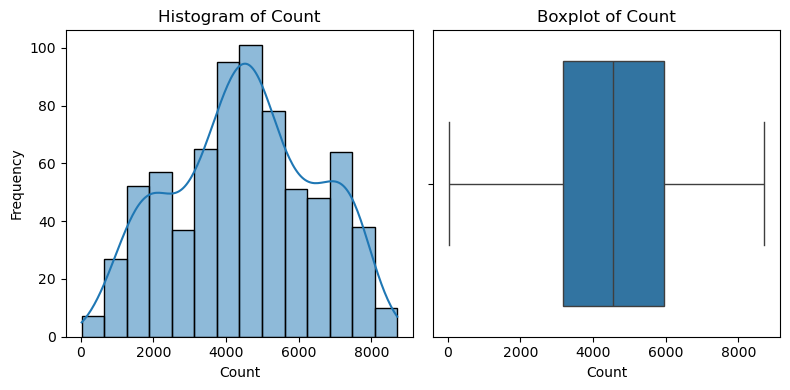

In [11]:
# Lets analyze Taget variable
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
# Plot the histogram on the first axis
sns.histplot(data=bike_df, x='count', ax=axes[0], kde=True)
axes[0].set_title('Histogram of Count')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Frequency')

# Plot the boxplot on the second axis
sns.boxplot(data=bike_df, x='count', ax=axes[1])
axes[1].set_title('Boxplot of Count')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

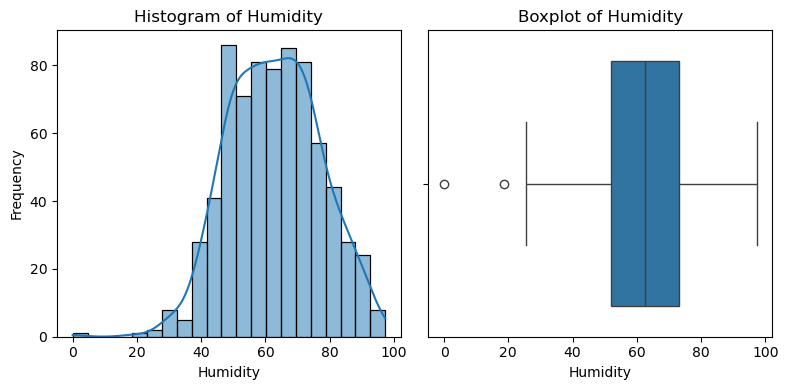

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
# Plot the histogram on the first axis
sns.histplot(data=bike_df, x='humidity', ax=axes[0], kde=True)
axes[0].set_title('Histogram of Humidity')
axes[0].set_xlabel('Humidity')
axes[0].set_ylabel('Frequency')

# Plot the boxplot on the second axis
sns.boxplot(data=bike_df, x='humidity', ax=axes[1])
axes[1].set_title('Boxplot of Humidity')
axes[1].set_xlabel('Humidity')

plt.tight_layout()
plt.show()

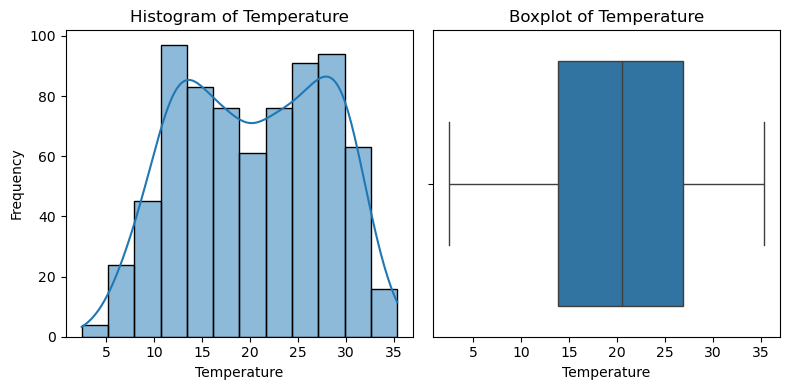

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
# Plot the histogram on the first axis
sns.histplot(data=bike_df, x='temp', ax=axes[0], kde=True)
axes[0].set_title('Histogram of Temperature')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Frequency')

# Plot the boxplot on the second axis
sns.boxplot(data=bike_df, x='temp', ax=axes[1])
axes[1].set_title('Boxplot of Temperature')
axes[1].set_xlabel('Temperature')

plt.tight_layout()
plt.show()

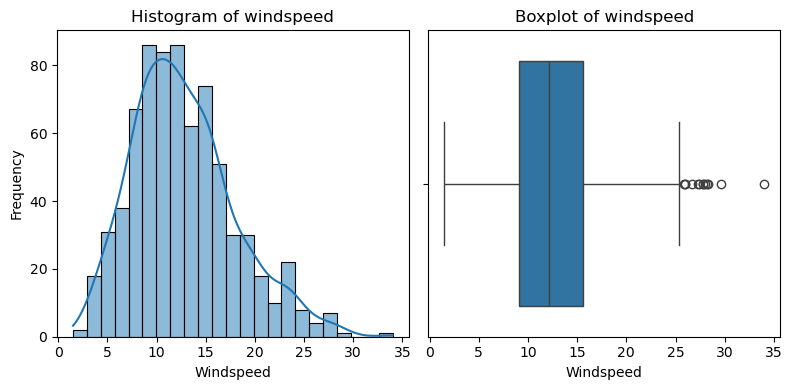

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
# Plot the histogram on the first axis
sns.histplot(data=bike_df, x='windspeed', ax=axes[0], kde=True)
axes[0].set_title('Histogram of windspeed')
axes[0].set_xlabel('Windspeed')
axes[0].set_ylabel('Frequency')

# Plot the boxplot on the second axis
sns.boxplot(data=bike_df, x='windspeed', ax=axes[1])
axes[1].set_title('Boxplot of windspeed')
axes[1].set_xlabel('Windspeed')

plt.tight_layout()
plt.show()

### Categorical variable

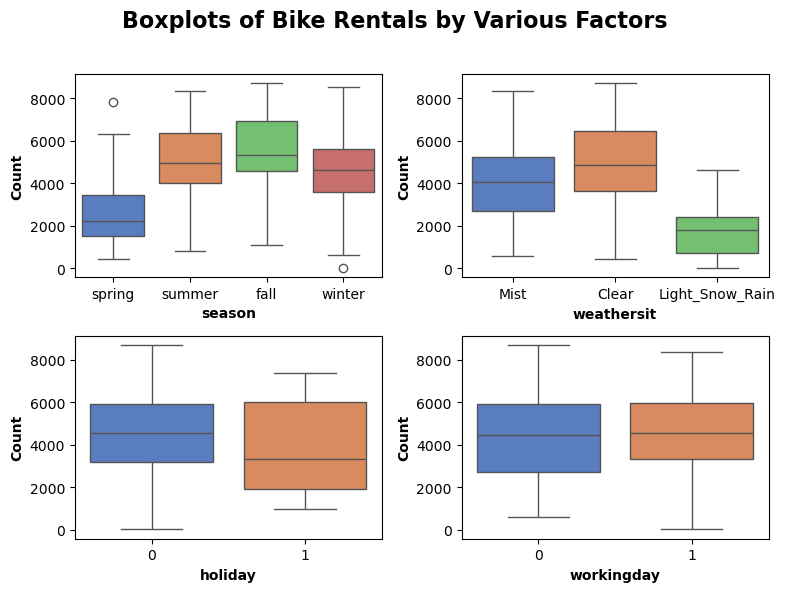

In [15]:
columns = ['season', 'weathersit', 'holiday', 'workingday']
# Setting up the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

# Formatting Figure
fig.suptitle('Boxplots of Bike Rentals by Various Factors', fontsize=16, fontweight='bold')

# Flatten the axes array for easy iteration
axes = axes.flatten()
for ax, var in zip(axes, columns):
    sns.boxplot(ax=ax, x=var, y='count', data=bike_df, palette='muted')
    ax.set_xlabel(var, fontsize=10, fontweight='bold')
    ax.set_ylabel('Count', fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

### Numerical Variable

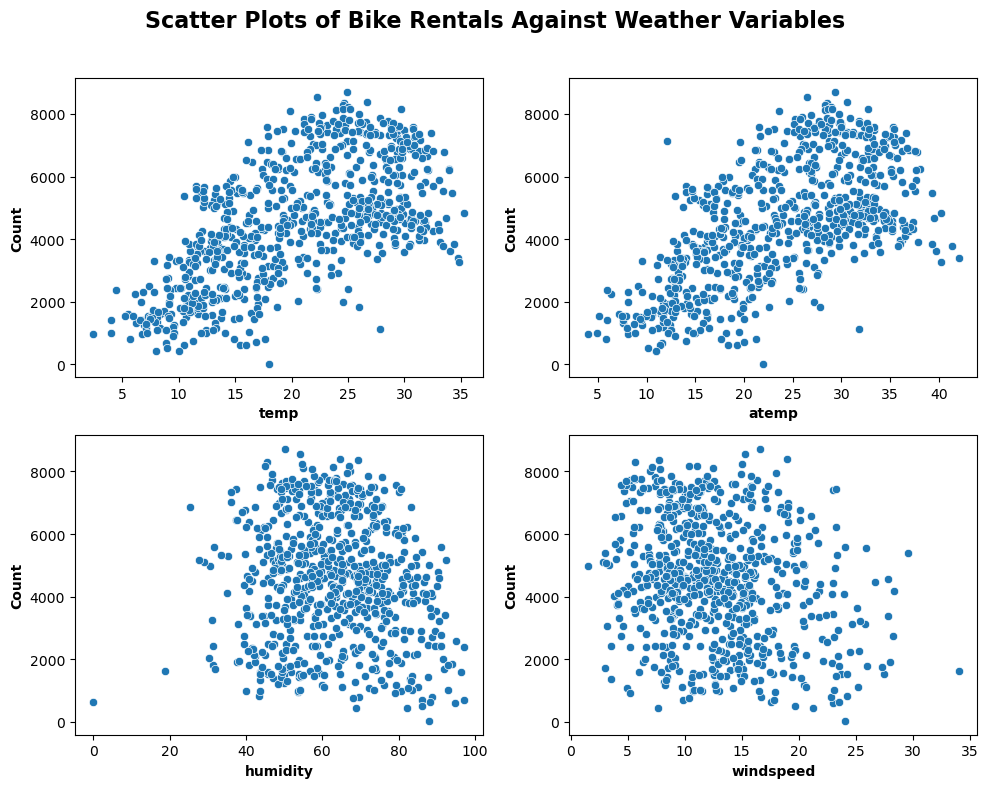

In [16]:
columns = ['temp', 'atemp', 'humidity', 'windspeed']
# Setting up the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Formatting Figure
fig.suptitle('Scatter Plots of Bike Rentals Against Weather Variables', fontsize=16, fontweight='bold')

# Flatten the axes array for easy iteration
axes = axes.flatten()
for ax, var in zip(axes, columns):
    sns.scatterplot(ax=ax, x=var, y='count', data=bike_df, palette='muted')
    ax.set_xlabel(var, fontsize=10, fontweight='bold')
    ax.set_ylabel('Count', fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

***Inference***:
- Temperature (both actual and apparent) seems to be a significant factor in bike rentals, with warmer conditions leading to higher rental counts.
- Humidity and windspeed appear to have less pronounced effects, though high humidity and high windspeed might slightly deter rentals.

<Figure size 600x400 with 0 Axes>

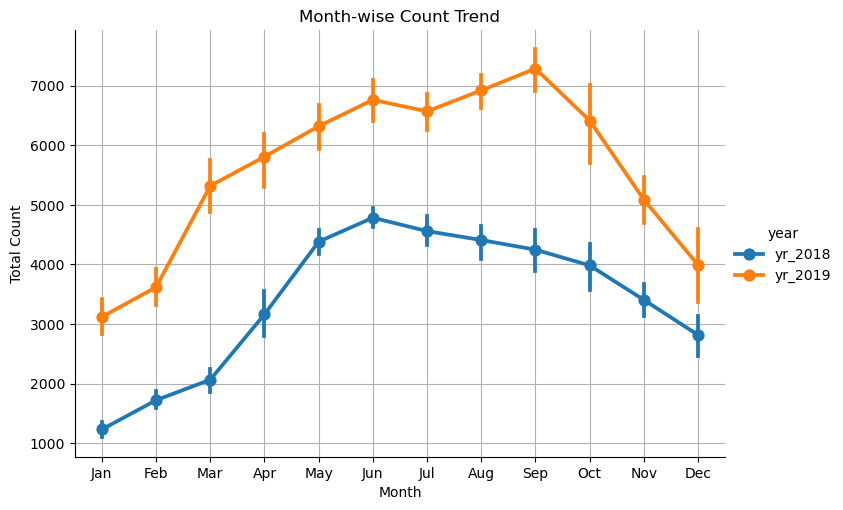

In [17]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(6, 4))
sns.catplot(data=bike_df, x='month', y='count', order=month_order, kind="point", hue='year', marker='o', aspect=1.5)
plt.title('Month-wise Count Trend')
plt.xlabel('Month')
plt.ylabel('Total Count')
plt.grid(True)
plt.show()

In [18]:
bike_df.drop(['date', 'casual', 'registered'], inplace=True, axis=1)

# 4. Feature Engineering <a id="feature"></a>

In [19]:
bike_df.columns

Index(['season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'humidity', 'windspeed', 'count'],
      dtype='object')

In [20]:
season_dummy = pd.get_dummies(bike_df.season, drop_first=True, dtype=int)
month_dummy = pd.get_dummies(bike_df.month, drop_first=True, dtype=int)
year_dummy = pd.get_dummies(bike_df.year, drop_first=True, dtype=int)
weather_dummy = pd.get_dummies(bike_df.weathersit, drop_first=True, dtype=int)
weekday_dummy = pd.get_dummies(bike_df.weekday, drop_first=True, dtype=int)

In [21]:
weather_dummy

,Light_Snow_Rain,Mist
instant,,
1,0,1
2,0,1
3,0,0
4,0,0
5,0,0
...,...,...
726,0,1
727,0,1
728,0,1


In [22]:
df_with_dummies = pd.concat([bike_df, season_dummy, year_dummy, month_dummy, weather_dummy, weekday_dummy], axis=1)
df_with_dummies.drop(['season', 'month', 'weathersit', 'weekday', 'year'], axis=1, inplace=True)

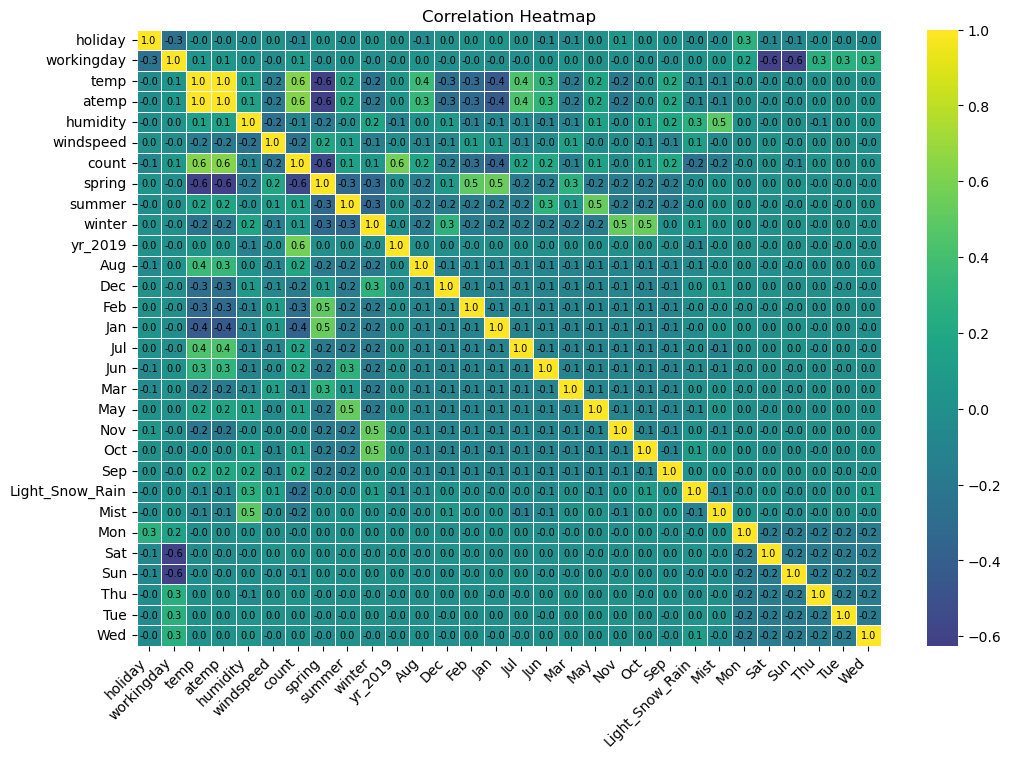

In [23]:
cmap = sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(12, 8))

sns.heatmap(df_with_dummies.corr(), cmap=cmap, annot=True, fmt=".1f", linewidths=0.5, center=0,annot_kws={"size": 7, "color": "black"})
# Add titles and labels
plt.title('Correlation Heatmap', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the heatmap
plt.show()

We can clearly see that some dummy variable are correlated to each other so trying not to drop first columns from dummy and  doing it manually

In [24]:
weather_dummy = pd.get_dummies(bike_df.weathersit, dtype=int)
weekday_dummy = pd.get_dummies(bike_df.weekday, dtype=int)


In [25]:
bike_df = pd.concat([bike_df, season_dummy, year_dummy, month_dummy, weather_dummy, weekday_dummy], axis=1)
bike_df.drop(['season', 'month', 'weathersit', 'weekday', 'year'], axis=1, inplace=True)

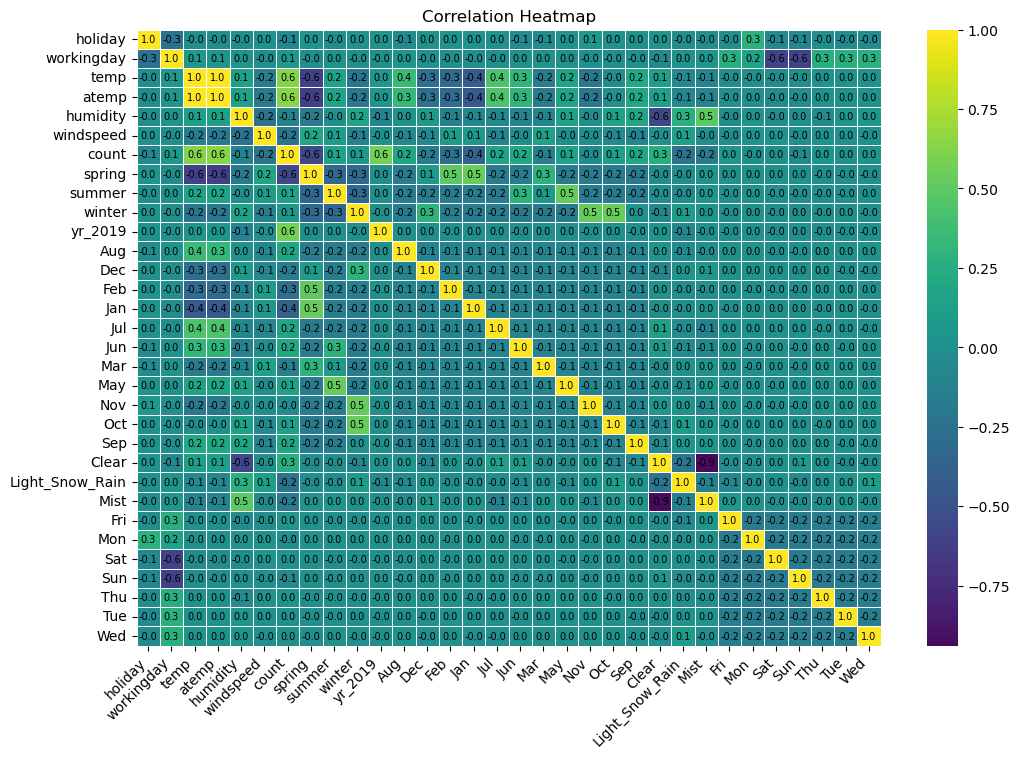

In [26]:
cmap = sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(12, 8))

sns.heatmap(bike_df.corr(), cmap=cmap, annot=True, fmt=".1f", linewidths=0.5, center=0,annot_kws={"size": 7, "color": "black"})
# Add titles and labels
plt.title('Correlation Heatmap', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the heatmap
plt.show()

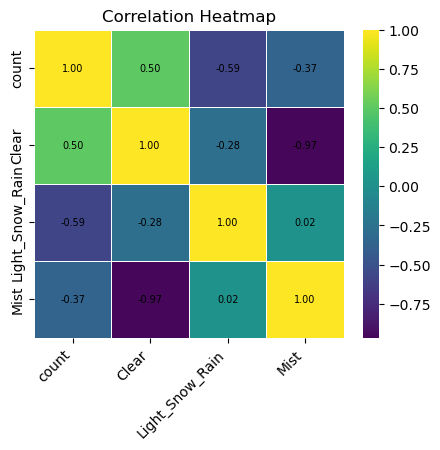

In [27]:
corr_matrix = bike_df[['count', 'Clear', 'Light_Snow_Rain', 'Mist' ]].corr()
cmap = sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix.corr(), cmap=cmap, annot=True, fmt=".2f", linewidths=0.5, center=0,annot_kws={"size": 7, "color": "black"})
# Add titles and labels
plt.title('Correlation Heatmap', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the heatmap
plt.show()

In [28]:
bike_df.drop('Mist', axis=1, inplace=True)

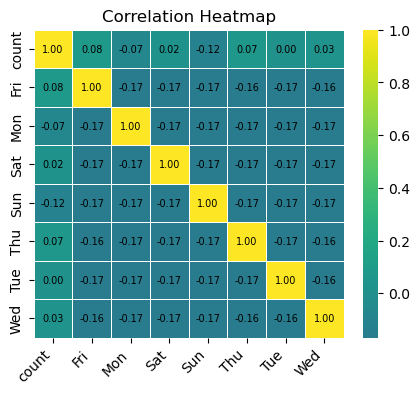

In [29]:
corr_matrix = bike_df[['count', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed' ]].corr()
cmap = sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix.corr(), cmap=cmap, annot=True, fmt=".2f", linewidths=0.5, center=0,annot_kws={"size": 7, "color": "black"})
# Add titles and labels
plt.title('Correlation Heatmap', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the heatmap
plt.show()

In [30]:
bike_df.drop('Tue', axis=1, inplace=True)

#### Splitting the Data into Training and Testing Sets

In [31]:
df_train, df_test = train_test_split(bike_df, train_size=0.7, test_size=0.3, random_state=100)

#### Rescaling the Features

In [32]:
scaler = MinMaxScaler()

In [33]:
df_train.columns

Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'count', 'spring', 'summer', 'winter', 'yr_2019', 'Aug', 'Dec', 'Feb',
       'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Clear',
       'Light_Snow_Rain', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Wed'],
      dtype='object')

In [34]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'atemp', 'humidity', 'windspeed', 'count']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [35]:
df_train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,spring,summer,winter,...,Oct,Sep,Clear,Light_Snow_Rain,Fri,Mon,Sat,Sun,Thu,Wed
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620,0.243137,0.245098,0.24902,...,0.086275,0.080392,0.627451,0.029412,0.127451,0.150980,0.154902,0.143137,0.133333,0.158824
std,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593,0.429398,0.430568,0.43287,...,0.281045,0.272166,0.483958,0.169124,0.333805,0.358381,0.362166,0.350557,0.340268,0.365870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividung into X and Y sets for the model building

In [36]:
y_train = df_train.pop('count')
X_train = df_train
y_test = df_test.pop('count')
X_test = df_test

# 5. Model Building and Feature Selection <a id="model"></a>

## 5.1. Feature Selection Using Recursive Feature Elimination (RFE) <a id='rfe'></a>

In [37]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [38]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('yr_2019', True, 1),
 ('Aug', False, 8),
 ('Dec', False, 4),
 ('Feb', False, 5),
 ('Jan', False, 2),
 ('Jul', True, 1),
 ('Jun', False, 13),
 ('Mar', False, 14),
 ('May', False, 7),
 ('Nov', False, 3),
 ('Oct', False, 12),
 ('Sep', True, 1),
 ('Clear', True, 1),
 ('Light_Snow_Rain', True, 1),
 ('Fri', False, 9),
 ('Mon', False, 15),
 ('Sat', True, 1),
 ('Sun', True, 1),
 ('Thu', False, 11),
 ('Wed', False, 10)]

In [39]:
col = X_train.columns[rfe.support_]
col

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'spring',
       'summer', 'winter', 'yr_2019', 'Jul', 'Sep', 'Clear', 'Light_Snow_Rain',
       'Sat', 'Sun'],
      dtype='object')

In [40]:
X_train.columns[~rfe.support_]

Index(['atemp', 'Aug', 'Dec', 'Feb', 'Jan', 'Jun', 'Mar', 'May', 'Nov', 'Oct',
       'Fri', 'Mon', 'Thu', 'Wed'],
      dtype='object')

In [41]:
def linear_reg(X_train, y_train, X_test, y_test):
    X_train_lm = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_lm).fit()
    X_test_lm = sm.add_constant(X_test)
    y_pred_train = model.predict(X_train_lm)
    y_pred_test= model.predict(X_test_lm)
    print("R2 Score of the training data:",r2_score(y_pred = y_pred_train, y_true = y_train))
    print("R2 Score of the testing data:",r2_score(y_pred = y_pred_test, y_true = y_test))
    print(model.summary())
    plt.show()
    return model

In [42]:
def get_stats(model, X):
    # Add a constant to X (just as it was added during the model fitting)
    X_with_const = sm.add_constant(X)
    
    # Calculate p-values and VIF
    stats = pd.DataFrame(data=model.pvalues, columns=['Pvalue'])
    stats['feature'] = stats.index
    
    # Ensure VIF calculation includes the constant
    stats['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    
    stats.reset_index(drop=True, inplace=True)
    stats['Pvalue'] = stats['Pvalue'].round(3)
    
    # Sort by p-value in descending order
    stats = stats.sort_values(by='Pvalue', ascending=False)
    return stats

## 5.2. Model Development and Comparison <a id='models'></a>

### Base Model

In [43]:
X_train_lm = X_train[col]
X_test_lm = X_test[col]

In [44]:
model_0 = linear_reg(X_train_lm, y_train, X_test_lm, y_test)

R2 Score of the training data: 0.8473834224036465
R2 Score of the testing data: 0.8169053120312771
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          1.13e-191
Time:                        15:00:07   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [45]:
get_stats(model_0, X_train_lm)

,Pvalue,feature,VIF
1,0.158,holiday,inf
15,0.024,Sun,inf
6,0.007,spring,5.018673
10,0.003,Jul,1.487435
0,0.000,const,0.000000
2,0.000,workingday,inf
3,0.000,temp,3.615608
4,0.000,humidity,1.910052
5,0.000,windspeed,1.195997
7,0.000,summer,2.614621


### Model 1

In [46]:
# dropping holiday
col = ['workingday', 'temp', 'humidity', 'windspeed', 'spring',
       'summer', 'winter', 'yr_2019', 'Jul', 'Sep', 'Clear', 'Light_Snow_Rain',
       'Sat', 'Sun']
X_train_lm = X_train[col]
X_test_lm = X_test[col]
model_1 = linear_reg(X_train_lm, y_train, X_test_lm, y_test)

R2 Score of the training data: 0.8473834224036465
R2 Score of the testing data: 0.8169053120312773
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          1.13e-191
Time:                        15:00:07   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [47]:
get_stats(model_1, X_train_lm)

,Pvalue,feature,VIF
14,0.028,Sun,5.737758
0,0.007,const,131.750623
5,0.007,spring,5.018673
9,0.003,Jul,1.487435
1,0.000,workingday,9.070901
2,0.000,temp,3.615608
3,0.000,humidity,1.910052
4,0.000,windspeed,1.195997
6,0.000,summer,2.614621
7,0.000,winter,3.493578


### Model 2

In [48]:
# dropping Sun
col = ['workingday', 'temp', 'humidity', 'windspeed', 'spring',
       'summer', 'winter', 'yr_2019', 'Jul', 'Sep', 'Clear', 'Light_Snow_Rain',
       'Sat']
X_train_lm = X_train[col]
X_test_lm = X_test[col]
model_2 = linear_reg(X_train_lm, y_train, X_test_lm, y_test)

R2 Score of the training data: 0.8458835517243486
R2 Score of the testing data: 0.8170948517367603
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     209.4
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          8.51e-192
Time:                        15:00:07   Log-Likelihood:                 515.37
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     496   BIC:                            -943.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [49]:
get_stats(model_2, X_train_lm)

,Pvalue,feature,VIF
5,0.006,spring,5.015882
9,0.003,Jul,1.486200
0,0.000,const,98.444268
1,0.000,workingday,1.652462
2,0.000,temp,3.615601
3,0.000,humidity,1.909297
4,0.000,windspeed,1.195867
6,0.000,summer,2.614322
7,0.000,winter,3.491312
8,0.000,yr_2019,1.034485


### Model 3

In [50]:
# dropping spring
col = ['workingday', 'temp', 'humidity', 'windspeed',
       'summer', 'winter', 'yr_2019', 'Jul', 'Sep', 'Clear', 'Light_Snow_Rain',
       'Sat']
X_train_lm = X_train[col]
X_test_lm = X_test[col]
model_3 = linear_reg(X_train_lm, y_train, X_test_lm, y_test)

R2 Score of the training data: 0.8435568669507005
R2 Score of the testing data: 0.8062100465610857
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     223.3
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          2.26e-191
Time:                        15:00:07   Log-Likelihood:                 511.55
No. Observations:                 510   AIC:                            -997.1
Df Residuals:                     497   BIC:                            -942.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [51]:
get_stats(model_3, X_train_lm)

,Pvalue,feature,VIF
8,0.014,Jul,1.431499
0,0.001,const,70.885053
1,0.000,workingday,1.651761
2,0.000,temp,1.603084
3,0.000,humidity,1.885433
4,0.000,windspeed,1.182748
5,0.000,summer,1.325892
6,0.000,winter,1.287599
7,0.000,yr_2019,1.030272
9,0.000,Sep,1.187347


### Model 4

In [52]:
# dropping Sun
col = ['workingday', 'temp', 'humidity', 'windspeed',
       'summer', 'winter', 'yr_2019', 'Jul', 'Sep', 'Clear', 'Light_Snow_Rain',
       'Sat', 'holiday']
X_train_lm = X_train[col]
X_test_lm = X_test[col]
model_4 = linear_reg(X_train_lm, y_train, X_test_lm, y_test)

R2 Score of the training data: 0.8451452781142546
R2 Score of the testing data: 0.8064517675562802
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     208.2
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          2.77e-191
Time:                        15:00:07   Log-Likelihood:                 514.15
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     496   BIC:                            -941.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [53]:
get_stats(model_4, X_train_lm)


,Pvalue,feature,VIF
13,0.025,holiday,1.161438
8,0.011,Jul,1.433150
0,0.000,const,72.306075
1,0.000,workingday,1.878902
2,0.000,temp,1.604390
3,0.000,humidity,1.886001
4,0.000,windspeed,1.182947
5,0.000,summer,1.327834
6,0.000,winter,1.287757
7,0.000,yr_2019,1.030407


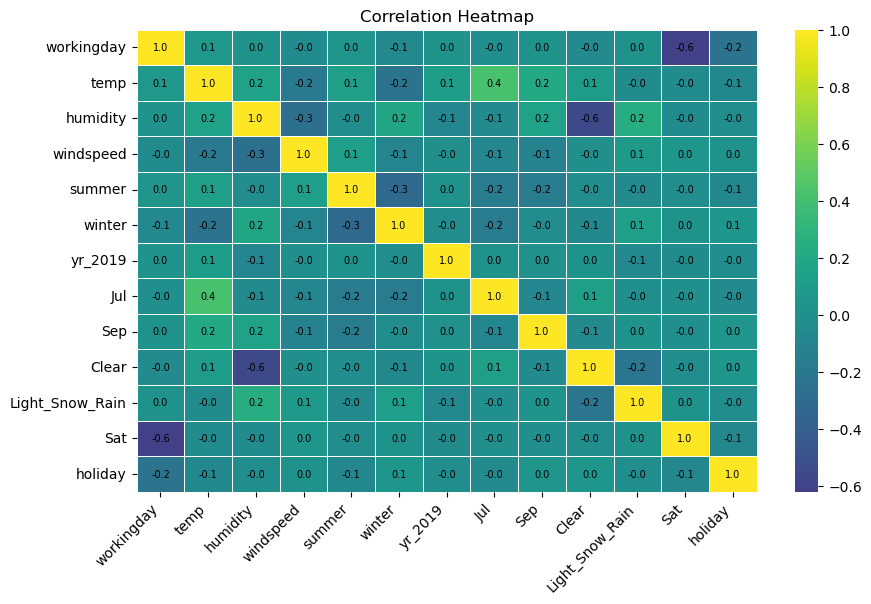

In [54]:
cmap = sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(10, 6))

sns.heatmap(X_train[col].corr(), cmap=cmap, annot=True, fmt=".1f", linewidths=0.5, center=0,annot_kws={"size": 7, "color": "black"})
# Add titles and labels
plt.title('Correlation Heatmap', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the heatmap
plt.show()

### Model 5

In [55]:
col = ['workingday', 'temp', 'humidity', 'windspeed',
       'summer', 'winter', 'yr_2019', 'Sep', 'Clear', 'Light_Snow_Rain', 'holiday', 'Sat']
X_train_lm = X_train[col]
X_test_lm = X_test[col]
model_5 = linear_reg(X_train_lm, y_train, X_test_lm, y_test)

R2 Score of the training data: 0.8431121711564674
R2 Score of the testing data: 0.8066672608110939
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     222.6
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          4.55e-191
Time:                        15:00:08   Log-Likelihood:                 510.83
No. Observations:                 510   AIC:                            -995.7
Df Residuals:                     497   BIC:                            -940.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [56]:
get_stats(model_5, X_train_lm)

,Pvalue,feature,VIF
11,0.031,holiday,1.160100
0,0.000,const,72.288004
1,0.000,workingday,1.875497
2,0.000,temp,1.273740
3,0.000,humidity,1.871658
4,0.000,windspeed,1.181248
5,0.000,summer,1.191725
6,0.000,winter,1.254354
7,0.000,yr_2019,1.028384
8,0.000,Sep,1.115848


### Model 6

In [57]:
col = ['workingday', 'temp', 'humidity', 'windspeed',
       'summer', 'winter', 'yr_2019', 'Sep', 'Clear', 'Light_Snow_Rain', 'Sat']
X_train_lm = X_train[col]
X_test_lm = X_test[col]
model_6 = linear_reg(X_train_lm, y_train, X_test_lm, y_test)

R2 Score of the training data: 0.8416417274131027
R2 Score of the testing data: 0.8058858263090352
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     240.6
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          2.89e-191
Time:                        15:00:08   Log-Likelihood:                 508.45
No. Observations:                 510   AIC:                            -992.9
Df Residuals:                     498   BIC:                            -942.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [58]:
get_stats(model_6, X_train_lm)

,Pvalue,feature,VIF
0,0.001,const,70.876213
1,0.000,workingday,1.649980
2,0.000,temp,1.270639
3,0.000,humidity,1.871267
4,0.000,windspeed,1.181007
5,0.000,summer,1.190729
6,0.000,winter,1.254001
7,0.000,yr_2019,1.028282
8,0.000,Sep,1.111397
9,0.000,Clear,1.617980


### Model 7

In [59]:
col = ['temp', 'humidity', 'windspeed',
       'summer', 'winter', 'yr_2019', 'Sep', 'Light_Snow_Rain']
X_train_lm = X_train[col]
X_test_lm = X_test[col]
model_7 = linear_reg(X_train_lm, y_train, X_test_lm, y_test)

R2 Score of the training data: 0.8258190764907138
R2 Score of the testing data: 0.799690380419737
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     296.9
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          1.12e-184
Time:                        15:00:08   Log-Likelihood:                 484.16
No. Observations:                 510   AIC:                            -950.3
Df Residuals:                     501   BIC:                            -912.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [60]:
get_stats(model_7, X_train_lm)

,Pvalue,feature,VIF
0,0.0,const,40.045212
1,0.0,temp,1.201513
2,0.0,humidity,1.249062
3,0.0,windspeed,1.158026
4,0.0,summer,1.189019
5,0.0,winter,1.241933
6,0.0,yr_2019,1.024463
7,0.0,Sep,1.110789
8,0.0,Light_Snow_Rain,1.104711


## 5.3. Selecting the Best Model <a id='best_model'></a>

In [61]:
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]  

# Create an empty DataFrame to store the metrics
model_comparison = pd.DataFrame(columns=['Model', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'AIC', 'BIC'])

# Loop through each fitted model and extract the statistics
for i, model in enumerate(models, start=1):
    # Create a DataFrame for the current model's statistics
    model_stats = pd.DataFrame({
        'Model': [f'Model_{i}'],
        'R-squared': [model.rsquared],
        'Adjusted R-squared': [model.rsquared_adj],
        'F-statistic': [model.fvalue],
        'AIC': [model.aic],
        'BIC': [model.bic]
    })

    # Concatenate the current model's statistics with the main DataFrame
    model_comparison = pd.concat([model_comparison, model_stats], ignore_index=True)

# Display the DataFrame with results
model_comparison

,Model,R-squared,Adjusted R-squared,F-statistic,AIC,BIC
0,Model_1,0.847383,0.843067,196.315873,-1005.731811,-942.215650
1,Model_2,0.845884,0.841844,209.411203,-1002.744150,-943.462400
2,Model_3,0.843557,0.839780,223.322768,-997.102258,-942.054918
3,Model_4,0.845145,0.841087,208.230931,-1000.306898,-941.025148
4,Model_5,0.843112,0.839324,222.572369,-995.654619,-940.607280
5,Model_6,0.841642,0.838144,240.615257,-992.896865,-942.083936
6,Model_7,0.825819,0.823038,296.914947,-950.327252,-912.217555


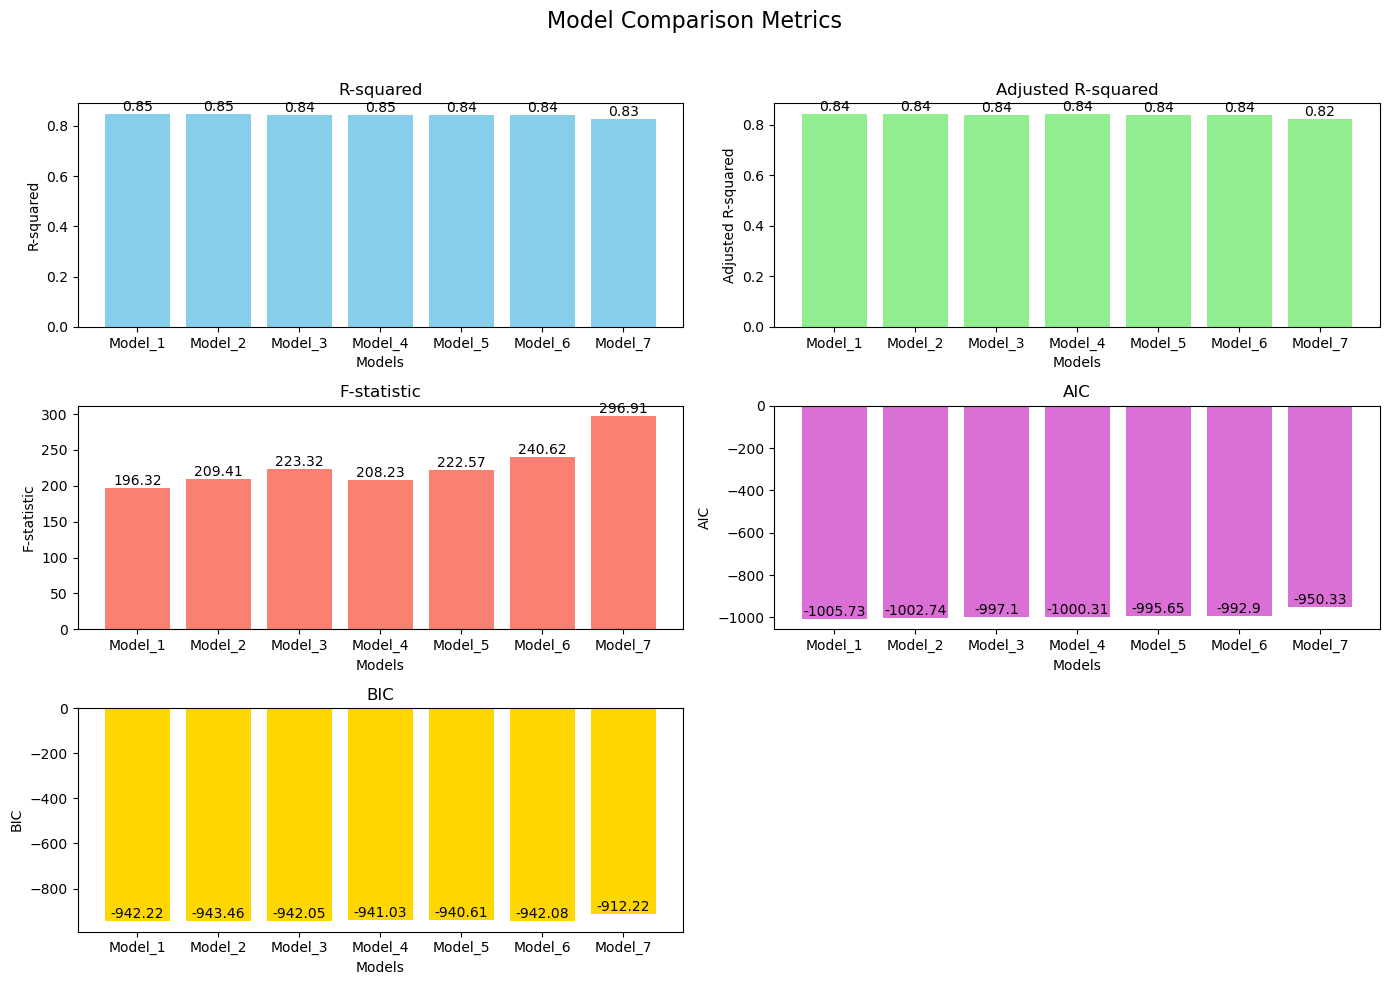

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Model Comparison Metrics', fontsize=16)

# Function to add values on bars
def add_values_on_bars(ax, bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Plot each metric on a separate subplot and add values on bars
bars_r2 = axes[0, 0].bar(model_comparison['Model'], model_comparison['R-squared'], color='skyblue')
axes[0, 0].set_title('R-squared')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('R-squared')
add_values_on_bars(axes[0, 0], bars_r2)

bars_adj_r2 = axes[0, 1].bar(model_comparison['Model'], model_comparison['Adjusted R-squared'], color='lightgreen')
axes[0, 1].set_title('Adjusted R-squared')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Adjusted R-squared')
add_values_on_bars(axes[0, 1], bars_adj_r2)

bars_fstat = axes[1, 0].bar(model_comparison['Model'], model_comparison['F-statistic'], color='salmon')
axes[1, 0].set_title('F-statistic')
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('F-statistic')
add_values_on_bars(axes[1, 0], bars_fstat)

bars_aic = axes[1, 1].bar(model_comparison['Model'], model_comparison['AIC'], color='orchid')
axes[1, 1].set_title('AIC')
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('AIC')
add_values_on_bars(axes[1, 1], bars_aic)

bars_bic = axes[2, 0].bar(model_comparison['Model'], model_comparison['BIC'], color='gold')
axes[2, 0].set_title('BIC')
axes[2, 0].set_xlabel('Models')
axes[2, 0].set_ylabel('BIC')
add_values_on_bars(axes[2, 0], bars_bic)

# Hide the last unused subplot
axes[2, 1].axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plot
plt.show()

**Best Model: Model_4**

***Reason for Selection***: Model_4 has one of the highest R-squared and Adjusted R-squared values, indicating strong explanatory power. It avoids the multicollinearity issue seen in Models 1 and 2, while still maintaining a favorable balance in AIC and BIC, making it a robust and reliable choice.

## 5.4. Final Model <a id='final_model'></a>

In [63]:
col = ['workingday', 'temp', 'humidity', 'windspeed',
       'summer', 'winter', 'yr_2019', 'Jul', 'Sep', 'Clear', 'Light_Snow_Rain',
       'Sat', 'holiday']
X_train_lm = X_train[col]
X_test_lm = X_test[col]
final_model = linear_reg(X_train_lm, y_train, X_test_lm, y_test)

R2 Score of the training data: 0.8451452781142546
R2 Score of the testing data: 0.8064517675562802
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     208.2
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          2.77e-191
Time:                        15:00:09   Log-Likelihood:                 514.15
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     496   BIC:                            -941.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

## 5.5. Model Evaluation <a id='model_evalution'></a>

### 5.5.1. Residual Analysis <a id='residual_analysis'></a>

In [64]:
residuals = final_model.resid
fitted_values = final_model.fittedvalues

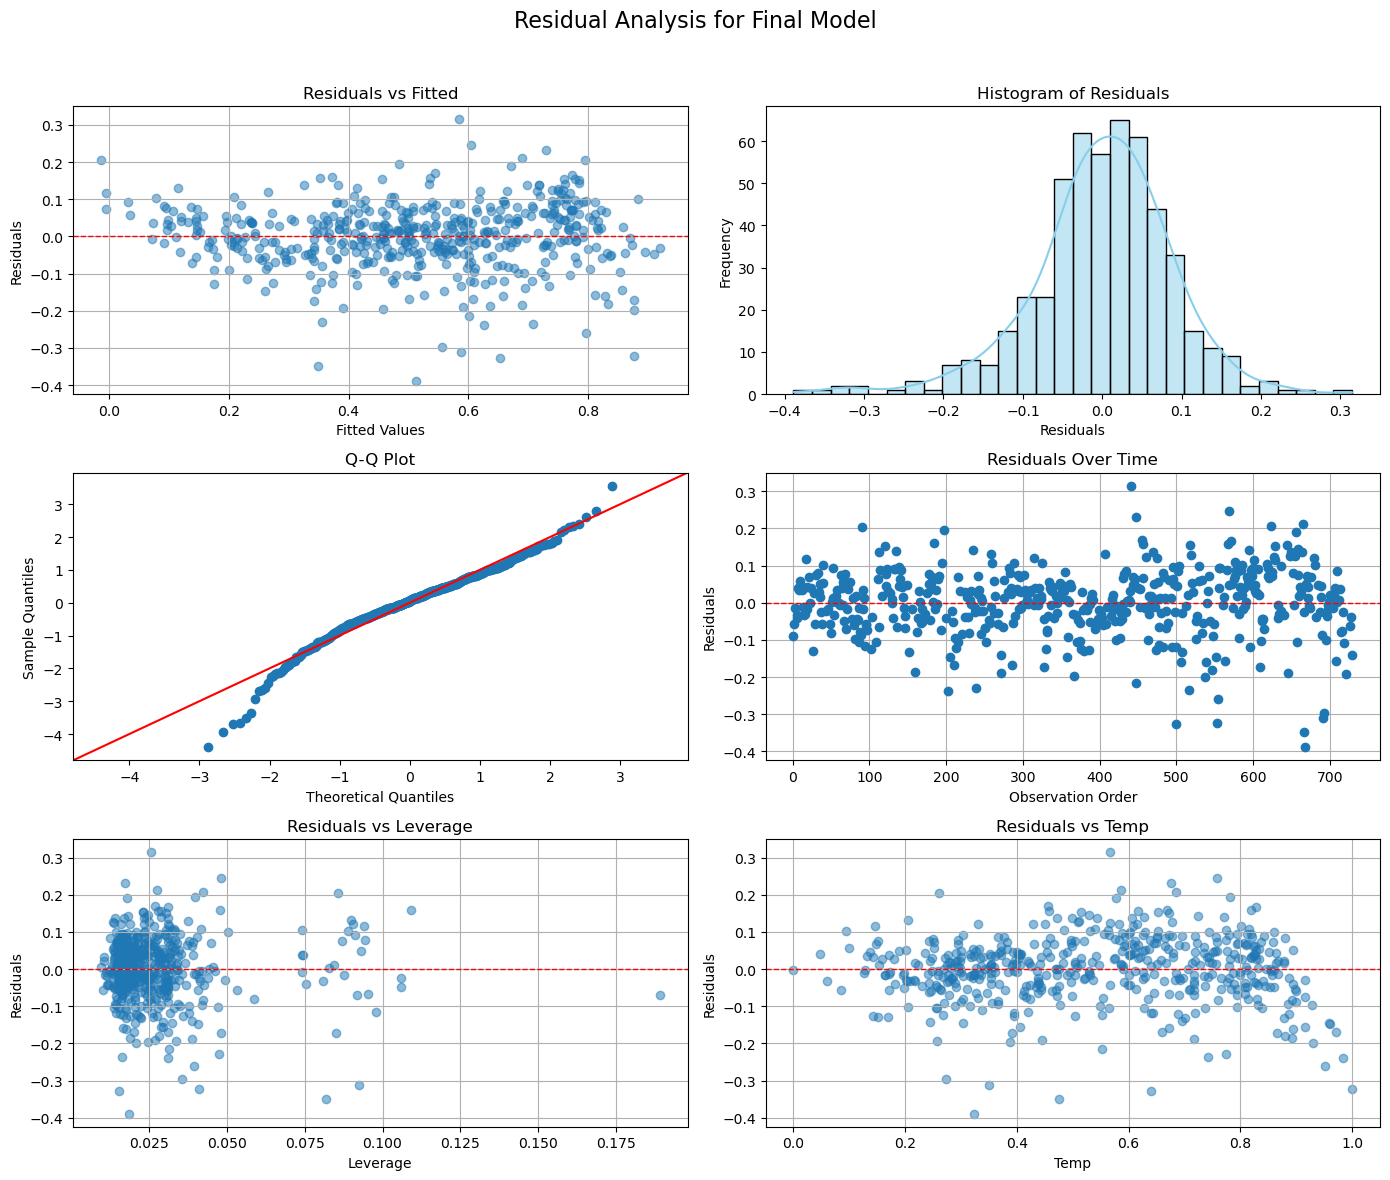

In [65]:
residuals = final_model.resid
fitted_values = final_model.fittedvalues

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Residual Analysis for Final Model', fontsize=16)

# 1. Residuals vs Fitted Values (Check for Homoscedasticity)
axes[0, 0].scatter(fitted_values, residuals, alpha=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True)

# 2. Histogram of Residuals (Check for Normality)
sns.histplot(residuals, kde=True, color='skyblue', bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')

# 3. Q-Q Plot (Check for Normality)
sm.qqplot(residuals, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. Residuals Over Time/Observation Order (Check for Independence)
axes[1, 1].plot(residuals, marker='o', linestyle='none')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('Residuals Over Time')
axes[1, 1].set_xlabel('Observation Order')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True)

# 5. Residuals vs Leverage
influence = final_model.get_influence()
leverage = influence.hat_matrix_diag
axes[2, 0].scatter(leverage, residuals, alpha=0.5)
axes[2, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[2, 0].set_title('Residuals vs Leverage')
axes[2, 0].set_xlabel('Leverage')
axes[2, 0].set_ylabel('Residuals')
axes[2, 0].grid(True)

# 6. Residuals vs Temp (Check for Functional Form)
axes[2, 1].scatter(X_train_lm['temp'], residuals, alpha=0.5)
axes[2, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[2, 1].set_title('Residuals vs Temp')
axes[2, 1].set_xlabel('Temp')
axes[2, 1].set_ylabel('Residuals')
axes[2, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 5.5.2. Test Data Predictions <a id='predicting_test_data'></a>

In [66]:
y_train_pred = final_model.predict(sm.add_constant(X_train_lm))
y_test_pred= final_model.predict(sm.add_constant(X_test_lm))

In [67]:
print("R2 Score of the testing data:",r2_score(y_pred = y_test_pred, y_true = y_test))

R2 Score of the testing data: 0.8064517675562802


Text(0, 0.5, 'Count')

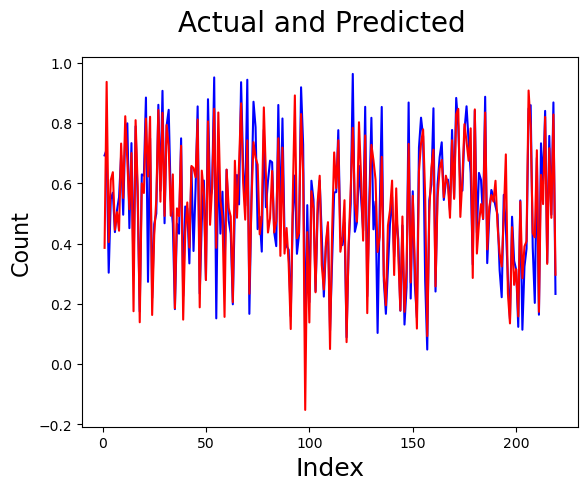

In [68]:
c = [i for i in range(1, 220)]  # Create a list of indices from 1 to 219
fig = plt.figure()
plt.plot(c, y_test, color="blue", linewidth=1.5, linestyle="-")  # Actual values
plt.plot(c, y_test_pred, color="red", linewidth=1.5, linestyle="-")  # Predicted values

fig.suptitle('Actual and Predicted', fontsize=20)  # Plot heading 
plt.xlabel('Index', fontsize=18)  # X-label
plt.ylabel('Count', fontsize=16)  # Y-label
# Y-label

# 6. Conclusions and Recommendations <a id='conclusions'></a>

1. **Focus on Temperature Management**
    * Insight: Temperature has the highest positive impact on bike rentals (coef = 0.5945), indicating that people prefer to rent bikes when the temperature is favorable.
    * Recommendation: Encourage bike rentals during optimal temperature conditions by offering discounts or promotions during cooler parts of the day in summer or providing shaded routes. Additionally, consider expanding operations in regions with moderate climates.
2. **Optimize for Weekdays and Holidays**
    * Insight: Rentals tend to decrease on holidays (coef = -0.0611) and increase on working days (coef = 0.0436).
    * Recommendation: Develop holiday-specific promotions or activities to attract customers, such as group rides, events, or special discounts. Consider partnerships with companies to encourage bike rentals as part of a commute program on working days.
3. **Seasonal Promotions**
    * Insight: Both summer (coef = 0.0806) and winter (coef = 0.1368) seasons show an increase in rentals, with winter having a stronger effect.
    * Recommendation: Tailor promotions based on the season. For instance, offer winter gear (gloves, jackets) for rentals in winter or hydration solutions in summer. Highlight seasonal attractions to encourage more rentals.
4. **Weather-Responsive Pricing**
    * Insight: Clear weather conditions lead to higher rentals (coef = 0.0554), while light snow or rain decreases rentals (coef = -0.1859).
    * Recommendation: Implement dynamic pricing based on weather conditions. Offer discounts or incentives on days with less favorable weather (light snow or rain) to encourage rentals despite the conditions.
5. **Weekend Focus**
    * Insight: Saturdays show an increase in rentals (coef = 0.0535).
    * Recommendation: Increase marketing efforts and special weekend packages to capitalize on the higher demand on Saturdays. Organize weekend events or rides to attract more customers.
6. **Monthly Campaigns**
    * Insight: July shows a decrease in rentals (coef = -0.0456), while September shows an increase (coef = 0.0945).
    * Recommendation: Identify why rentals drop in July and address it through targeted campaigns or offers. Conversely, capitalize on the positive trend in September by planning major marketing pushes or events.
7. **Yearly Growth Leverage**
    * Insight: The model shows a significant positive effect for the year 2019 (coef = 0.2284), indicating growth.
    * Recommendation: Use this momentum to further expand the business. Invest in marketing, increase bike availability, and explore new markets to sustain the growth trend.
8. **Strategic Partnerships**
    * Insight: Working days have a positive impact on rentals.
    * Recommendation: Partner with corporate offices, schools, and universities to promote bike rentals as a convenient and eco-friendly mode of transport. Offer subscription-based rentals for regular commuters.